In [1]:
from itertools import chain, product
from operator import sub
from pprint import pprint as print

import numpy as np
import pandarallel
import pandas as pd
import torch
from matplotlib import pyplot as plt
from scipy import stats
from scipy.spatial.distance import cdist, pdist
from tqdm import tqdm

In [2]:
pandarallel.pandarallel.initialize()

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [3]:
players_df = pd.read_pickle("chgk/players.pkl")
players_df = pd.DataFrame(players_df.values())

tour_df = pd.read_pickle("chgk/tournaments.pkl")
tour_df = pd.DataFrame(tour_df.values())
tour_df = tour_df.set_index("id")

res_df = pd.read_pickle("chgk/results.pkl")
# res_df = pd.DataFrame(res_df.values())

## train test split

In [4]:
START_DATE = "2019-01-01"
SPLIT_DATE = "2020-01-01"
END_DATE = "2021-01-01"

train = tour_df[(tour_df.dateStart >= START_DATE) & (tour_df.dateStart < SPLIT_DATE)]
test = tour_df[(tour_df.dateStart >= SPLIT_DATE) & (tour_df.dateStart < END_DATE)]

train_results = {i: res_df[i] for i in train.index if len(res_df[i]) > 0}
test_results = {i: res_df[i] for i in test.index if len(res_df[i]) > 0}

In [5]:
len(train_results), len(train_results), len(tour_df), len(players_df)

(680, 680, 5528, 204063)

### Data preprocessing

Удалим турниры(и команды в турнирах) где нет повопросных результатов

In [6]:
# step 1
def process_tournament_team_result(team_object: dict):
    try:
        if team_object["mask"] is None:
            return None
        if len(team_object["teamMembers"]) == 0:
            return None

        team_id = team_object["team"]["id"]
        team_members_ids = [
            player["player"]["id"] for player in team_object["teamMembers"]
        ]
        question_mask = np.array(
            list(map(int, list(team_object["mask"]))), dtype=np.int8
        )
    except Exception:
        return None

    return (team_id, team_members_ids, question_mask)


# step 2
def process_tournament_result(result_object: dict):
    teams_results = [
        process_tournament_team_result(team_result_object)
        for team_result_object in result_object
    ]
    return [r for r in teams_results if r is not None]


# step 3
def split_team_results_by_player(teams_results):
    res = []
    for _, players, mask in teams_results:
        for player in players:
            res.append((player, mask))
    player_ids, masks = zip(*res)
    return player_ids, masks


def pad_masks(masks):
    lengths = list(map(len, masks))
    max_len = max(lengths)
    masks = list(map(lambda m: (list(m) + [0] * max_len)[:max_len], masks))
    return masks


# merge steps for single tournament
def process_tournament(result_object: dict):
    teams_results = process_tournament_result(result_object)
    if len(teams_results) == 0:
        return None
    player_ids, masks = split_team_results_by_player(teams_results)
    masks = np.array(pad_masks(masks))
    questions_simplicity = 1 - np.mean(masks, axis=0)
    return player_ids, masks, questions_simplicity


# process all the tournaments
def process_all_tournaments(results_list: list[dict]):
    results = []
    for key, res in tqdm(results_list.items()):
        processed_tournament = process_tournament(res)
        if processed_tournament is not None:
            results.append(processed_tournament)
    return results

In [7]:
train_preprocessed = process_all_tournaments(train_results)
test_preprocessed = process_all_tournaments(test_results)

100%|████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:00<00:00, 481.53it/s]


In [8]:
players, masks, difficulties = train_preprocessed[1]

In [9]:
len(players), len(masks), len(difficulties)

(5272, 5272, 36)

In [10]:
dataset = []
global_question_idx = 0
for players, masks, difficulties in tqdm(train_preprocessed):
    for i, player_id in enumerate(players):
        for j in range(0, len(difficulties)):
            dataset.append(
                (player_id, global_question_idx + j, difficulties[j], masks[i][j])
            )
    global_question_idx += len(difficulties)

100%|████████████████████████████████████████████████████████████████████████████████████████| 616/616 [00:05<00:00, 107.58it/s]


In [11]:
df = pd.DataFrame(dataset, columns=["player_id", "question_id", "difficulty", "result"])

In [12]:
question_difficulties = (
    df[["question_id", "difficulty"]]
    .groupby("question_id", as_index=False)
    .mean()
    .difficulty
)
unique_players = df.player_id.unique()
known_players = set(unique_players)

In [13]:
max(unique_players)

224542

In [14]:
len(question_difficulties), len(unique_players)

(30521, 57288)

### Baseline model

Пусть есть:

вектор рейтингов всех игроков $r = [r_1, \ldots, r_{N_p}]^T$

вектор сложности всех вопросов $d = [d_1, \ldots, d_{N_{d}}]^T$ (для бэйзлайн модели взята просто доля неправильно ответивших команд)

матрица A ответов i-го игрока на k-ый вопрос $ a_{ik} = [\text{игрок } i \text{ правильно ответил на вопрос }k]$

**Моделировать будем логистической регрессией от рейтинга и сложности вопроса:**

$\hat{a}_{ik}= \sigma(r_i + \theta d_k  + b)  \approx a_{ik}$

в бейзлайн модели вектор d заморожен


In [15]:
class SimplePlayerRanker(torch.nn.Module):
    def __init__(self, n_players, n_questions, init_difficulties=None):
        super().__init__()
        self.ratings = torch.nn.Embedding(n_players, 1)
        self.difficulties = torch.nn.Embedding(n_questions, 1)
        self.theta = torch.nn.Parameter(torch.tensor(1.0))
        self.bias = torch.nn.Parameter(torch.rand(1))

        if init_difficulties is not None:
            with torch.no_grad():
                self.difficulties.weight.data = torch.tensor(init_difficulties)
                self.difficulties.requires_grad_(False)

    def decode(self, batch):
        player_ids, question_ids, targets = zip(*batch)
        ratings = self.ratings(torch.tensor(player_ids))
        difficulties = self.difficulties(torch.tensor(question_ids))
        targets = torch.tensor(targets, dtype=torch.float64).unsqueeze(1)

        return ratings, difficulties, targets

    def forward(self, ratings, difficulties):
        logits = ratings + difficulties * self.theta + self.bias
        probs = torch.nn.functional.sigmoid(logits)
        return probs

In [79]:
ranker = SimplePlayerRanker(
    max(unique_players) + 1,
    len(question_difficulties),
    init_difficulties=torch.tensor(question_difficulties).unsqueeze(1),
)

/tmp/ipykernel_1004/1513091899.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.difficulties.weight.data = torch.tensor(init_difficulties)


## Test ranking

Будем брать рейтинг команды как максимальный рейтинг игроков в команде (пробовал средний, но максимальный лучше кореллирует с фактическим ранжированием)
необученным игрокам присваиваем средний рейтинг


In [80]:
def get_team_rank(player_ids, ratings_emb):
    UNKNOWN_RATING = np.mean(ratings_emb.weight.data.squeeze().numpy())

    if len(player_ids) == 0:
        return UNKNOWN_RATING
    with torch.no_grad():
        ratings = [
            ratings_emb(torch.tensor(player_id)).numpy()[0]
            if player_id in known_players
            else UNKNOWN_RATING
            for player_id in player_ids
        ]
    return np.max(ratings)


def ranking_score(test_dataset, ratings_emb):
    scores = []
    for _, tournament in test_dataset.items():
        tournament_ranking = [
            (
                team["position"],
                get_team_rank(
                    [player["player"]["id"] for player in team["teamMembers"]],
                    ratings_emb,
                ),
            )
            for team in tournament
            if "position" in team
        ]
        if len(tournament_ranking) == 0:
            continue
        actual_ranking, predicted_ranking = zip(*tournament_ranking)

        correlation = stats.spearmanr(
            predicted_ranking, actual_ranking[::-1], nan_policy="omit"
        ).correlation

        if correlation is not np.nan:
            scores.append(correlation)

        return np.mean(scores)

In [81]:
ranking_score(test_results, ranker.ratings)

0.23017836493946253

## Trainig loop


In [82]:
train_data = df[["player_id", "question_id", "result"]].values

In [83]:
EPOCHS = 5
BATCH_SIZE = 1024*8
LR = 0.01

In [84]:
optimizer = torch.optim.Adam(ranker.parameters())

In [85]:
def get_batches(data, batch_size):
    for i in range(len(data) // batch_size):
        yield data[i * batch_size : (i + 1) * batch_size]

In [86]:
for i in range(EPOCHS):
    # shuffle df
    df = df.sample(frac=1)

    train_data = df[["player_id", "question_id", "result"]].values
    batches = get_batches(train_data, BATCH_SIZE)

    print(f"Ranking correlation: {ranking_score(test_results, ranker.ratings)}")
    pbar = tqdm(total=len(train_data) // BATCH_SIZE, position=0, leave=True)
    for batch in batches:
        optimizer.zero_grad()
        ratings, difficulties, targets = ranker.decode(batch)
        pred_probs = ranker.forward(ratings, difficulties)
        loss = torch.nn.functional.binary_cross_entropy(pred_probs, targets)
        loss.backward()
        optimizer.step()
        pbar.update()
        pbar.set_postfix({"loss": f"{loss.detach().numpy():.4f}"})

'Ranking correlation: 0.23017836493946253'


100%|█████████████████████████████████████████████████████████████████████████| 2558/2558 [00:30<00:00, 148.21it/s, loss=0.6251]

'Ranking correlation: 0.47735002285219696'


100%|█████████████████████████████████████████████████████████████████████████| 2558/2558 [00:32<00:00, 149.56it/s, loss=0.5253]

'Ranking correlation: 0.6128196082171091'


100%|█████████████████████████████████████████████████████████████████████████| 2558/2558 [00:35<00:00, 149.83it/s, loss=0.4750]

'Ranking correlation: 0.6770373475178011'


100%|█████████████████████████████████████████████████████████████████████████| 2558/2558 [00:33<00:00, 147.44it/s, loss=0.4601]

'Ranking correlation: 0.7155216244994432'


100%|█████████████████████████████████████████████████████████████████████████| 2558/2558 [00:31<00:00, 143.17it/s, loss=0.4562]

In [87]:
print(f"Ranking correlation: {ranking_score(test_results, ranker.ratings)}")

'Ranking correlation: 0.7182340705276674'


In [90]:
#torch.save(ranker.state_dict(), "ranker_weigths_0718.pt")

In [89]:
ranker.load_state_dict(torch.load("ranker_weigths_0718.pt"))

<All keys matched successfully>

In [92]:
ratings_emb = ranker.ratings
mean_rating = np.mean(ratings_emb.weight.data.squeeze().numpy())
mean_rating

-0.056475308

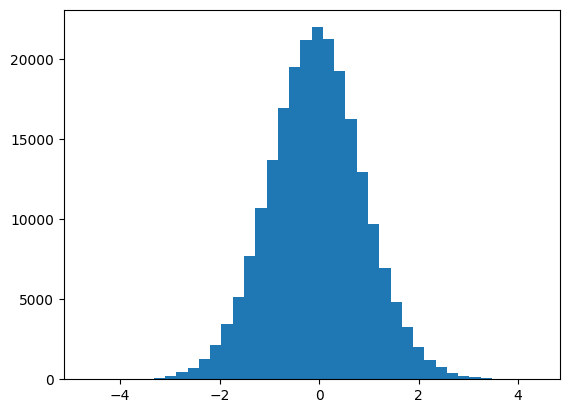

In [93]:
plt.hist(ratings_emb.weight.data.squeeze().numpy(), bins=40);

В бейзлайн модели получилась неплохая корреляция спирмена - 0.718

ЕМ-алгоритм я пока что не осилил. Если успею, постараюсь дополнить работу до того, как вы проверите её.